<h1>Extract Avulsion Site Slope and Plot Long Profiles</h1>

This notebook plots combined SRTM and ALOS3D surface models for each river, corresponding channel networks and avulsion locations to measure the distance upstream an avulsion site + calculate local slope.

Two long profiles are generated for
<ul>
    <li>Masked floodplain elevation models (Not including adjacent slopes)</li>
    <li>1000 km transects orthogonal to to the channel (Includes adjacent slopes)</li>
</ul>

The classification of a fan vs. a delta is made based on the ratio of the minimum vs. maximum slopes taken from the nearest bins to the avulsion nodes.

<h2> Method </h2>
Slopes are measured every 5000 m, which are then binned into 25 km non-overlapping windows. The median and IQR of the 5 slopes within a chosen window are then used as representative slopes

In [1]:
import os
import csv
import glob
import fiona
import rasterio
import rasterio.plot as rp
import numpy as np
import matplotlib as plt
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from scipy import stats, signal
from pylab import *
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import geopandas as gpd
import rasterio
from shapely.ops import nearest_points
from shapely.geometry import MultiPoint, Point
import json
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

channel_iqr_profiles = './profiles_without_floodplain'
channel_iqr_profiles_floodplain_mask = './profiles_no_filter'
channel_iqr_profiles_combined = './profiles/combined'
channel_planforms = './river_profiles/parent_channel_courses/UTM'
slope_window_m = 20000 # Every 25 km bin the slopes

minslope = 1e-5 # For nan slopes

output_dir = './elevation_data'
profile_suffix = ['_SRTM3', '_AW3D30', '_ASTGTMV003']

if not os.path.exists(output_dir):
    os.mkdir(output_dir)

def hillshade(delta, axes):
    with rasterio.open(delta) as d:
            dem = d.read(1)
            dem = dem.astype(rasterio.float32)
            dem[dem==0] = np.nan
            cmap = plt.cm.twilight_shifted
            scalebar = ScaleBar(d.transform[0]/22) # 1 pixel = 0.2 meter
            axes.add_artist(scalebar)
            rp.show(dem, ax=axes, cmap=cmap, transform=d.transform)
    
def raster_values(x_list,y_list, start_x, start_y, band,affine, start_reference=True):
    
    # Check beginning and last nodes to get the correct ordering
    
    d_start = math.hypot(start_x - x_list[0], start_y - y_list[0])
    d_end = math.hypot(start_x - x_list[-1], start_y - y_list[-1])
        
    if d_start > d_end:
        x_list = list(x_list)
        y_list = list(y_list)
        x_list.reverse()
        y_list.reverse()
        
    row, col = ~affine * (np.array(x_list), np.array(y_list)) # x, y to raster coords
    
    dims = band.shape
    
    coord_distances = []
    rasters_vals = []
    
    for x, y in zip(row, col):
        
        c = x.astype(int)
        r = y.astype(int)
        
        #if c < dims[0] and r < dims[1]:
            
        rasters_vals.append(band[r,c])
    
    
    cumulative_distance = []
    
    for n, x in enumerate(x_list):
        if n == 0:
            if start_reference:
                cumulative_distance.append(math.hypot(start_x - x, start_y - y_list[n]))
            else:
                cumulative_distance.append(0)
        else:
            cumulative_distance.append(cumulative_distance[n-1]+(math.hypot(x_list[n-1] - x, y_list[n-1] - y_list[n])))

    return rasters_vals, cumulative_distance, x_list, y_list

def get_closest_value(arr, target):
    n = len(arr)
    left = 0
    right = n - 1
    mid = 0

    # edge case - last or above all
    if target >= arr[n - 1]:
        return arr[n - 1]
    # edge case - first or below all
    if target <= arr[0]:
        return arr[0]
    # BSearch solution: Time & Space: Log(N)

    while left < right:
        mid = (left + right) // 2  # find the mid
        if target < arr[mid]:
            right = mid
        elif target > arr[mid]:
            left = mid + 1
        else:
            return arr[mid]

    if target < arr[mid]:
        return find_closest(arr[mid - 1], arr[mid], target)
    else:
        return find_closest(arr[mid], arr[mid + 1], target)


# findClosest
# We find the closest by taking the difference
# between the target and both values. It assumes
# that val2 is greater than val1 and target lies
# between these two. 
def find_closest(val1, val2, target):
    return val2 if target - val1 >= val2 - target else val1

def get_local_slope(x, y, interp=100, window=1000):
    
    new_x = list(range(int(min(x))+1, int(max(x))-1, interp))
    f = interp1d(x, y)
    new_y = f(new_x)
    
    slope_x = []
    slopes = []
    
    x_in_range = True
    x_target = min(new_x)
    
    while x_in_range is True:
        
        x_target +=window
        
        if x_target < max(new_x):
            
            start_val = get_closest_value(new_x, x_target-window)
            nearest_next_val = get_closest_value(new_x, x_target)
            start_idx = new_x.index(start_val)
            end_idx = new_x.index(nearest_next_val)
            query_d = new_x[start_idx:end_idx]
            mid_x = int((end_idx-start_idx)/2)
            query_z = new_y[start_idx:end_idx]
            
            rise = query_z[-1]-query_z[0]
            run = query_d[-1]-query_d[0]
            slope = rise/run
#             slope, intercept, r_value, p_value, std_err = stats.linregress(query_d,query_z)
            slopes.append(slope)
            slope_x.append(query_d[mid_x])
            
        else:
            x_in_range = False
    
    return slope_x, slopes

def get_slope_windows(delta_name, slope_binned, av_idx):
    
    down_wins = slope_windows[delta_name][0]
    up_wins = slope_windows[delta_name][1]
    
    downstream_idxs = False
    upstream_idxs = False
    
    upstream_idxs = list(range(av_idx+up_wins[0],av_idx+up_wins[1]))
    upstream_slopes = slope_binned.iloc[upstream_idxs]
    downstream_slopes = slope_binned.iloc[av_idx]
    downstream_idxs = [av_idx]

    return upstream_slopes, downstream_slopes, upstream_idxs, downstream_idxs

In [2]:
# Get Avulsion Distances using channel line vectors and avulsion point locations

import os
from shapely.geometry import shape, mapping, Point, LineString
from shapely.ops import nearest_points
from glob import glob
import pandas as pd

from pyproj import CRS
crs_4326 = CRS.from_epsg(4326)

avulsion_db = pd.read_csv(os.path.join('avulsion_locations', 'avulsion_db_4326_slope_param.csv'))
avulsion_db

AV_ID  year_est river_name     country   from  slope_process  \
0     AFR0211      1998  Catumbela      Angola  study              1   
1       ANGO2      2003   Coporolo      Angola  study              1   
2     ARG_001      2001       Sali   Argentina  study              1   
3   BETSIBOKA      2004        NaN  Madagascar  study              1   
4      BS0115      1995       Kura  Azerbaijan  study              1   
..        ...       ...        ...         ...    ...            ...   
86   TURK_002      1991        NaN      Turkey  study              1   
87    UZB_001      1994        NaN  Uzbekistan  study              1   
88     VENEZ1      1982  Catatumbo   Venezuela  study              1   
89     VENEZ2      1986      Misoa   Venezuela  study              1   
90     VENEZ2      2009      Misoa   Venezuela  study              1   

    reverse_needed  smoothing_windows_fp  smoothing_windows  \
0                0                   501                501   
1                0                  1001                501   
2                0                  1001                501   
3                0                  1001                501   
4                0                  1001               1501   
..             ...                   ...                ...   
86               0                  1001                501   
87               0                  1001                501   
88               0                  2501               1501   
89               0                  1001                501   
90               0                  1001                501   

    avulsion_slope_distances_upstream  ...  min_elevations_m  \
0                               25000  ...               NaN   
1                               25000  ...               NaN   
2                               25000  ...               NaN   
3                               25000  ...               NaN   
4                               25000  ...               NaN   
..                                ...  ...               ...   
86                              25000  ...               NaN   
87                              25000  ...               NaN   
88                              25000  ...               NaN   
89                              25000  ...               NaN   
90                              25000  ...               NaN   

    max_elevations_m  xtick_intervals_elevations_km  y_ticks_start  \
0                NaN                              1              0   
1                NaN                              1              0   
2                NaN                              1              0   
3                NaN                              1              0   
4                NaN                              1              0   
..               ...                            ...            ...   
86               NaN                              1              0   
87               NaN                              1              0   
88               NaN                              1              0   
89               NaN                              1              0   
90               NaN                              1              0   

    y_ticks_end  y_ticks_interval          HydroRIVER_src  Unnamed: 20    Wbf  \
0            50                10  HydroRIVERS_v10_af.shp          NaN  158.0   
1            50                10  HydroRIVERS_v10_af.shp          NaN  130.0   
2            50                10  HydroRIVERS_v10_sa.shp          NaN   50.0   
3            50                10  HydroRIVERS_v10_af.shp          NaN  500.0   
4            50                10  HydroRIVERS_v10_eu.shp          NaN  100.0   
..          ...               ...                     ...          ...    ...   
86           50                10  HydroRIVERS_v10_eu.shp          NaN   42.0   
87           50                10  HydroRIVERS_v10_as.shp          NaN   41.0   
88           50                10  HydroRIVERS_

In [3]:
import pickle
channel_paths = os.path.join('river_profiles', 'parent_channel_courses', 'UTM_interpolated')
downstream_channel_paths = os.path.join('river_profiles', 'parent_channel_courses', 'downstream_UTM_interpolated')
closest_points = os.path.join('avulsion_locations', 'closest_on_channel')
os.makedirs(closest_points, exist_ok=True)
os.makedirs(downstream_channel_paths, exist_ok=True)

avulsion_distances_static = {}

width_multiple = 20

missing_channel_data = []
missing_avulsion_loc_data = []

with open('avulsion_locations/avulsion_LA.pickle', 'rb') as handle:
    avulsion_distances_static = pickle.load(handle)
    
print(avulsion_distances_static)       


{'AFR0211_1998': [2049], 'ANGO2_2003': [16376], 'ARG_001_2001': [17141], 'BETSIBOKA_2004': [116592], 'BS0115_1995': [7780], 'CA0067_1986': [23647], 'CA0194_2007': [2459], 'CA0318-1_2002': [4316], 'CASP1_1991': [3430], 'CON_001_2013': [1837], 'CON_002': [6257], 'DANUBE': [125390], 'ECN0095_1999': [710], 'FIHERENANA_2001': [4828], 'HUANGHE_1930': [85913], 'JA_2_Taquari_1998': [248667], 'JA_10_Iran_2009_2009': [6987], 'JA_12_Eritrea': [2400], 'JA_18_PNG_1994_1994': [6180], 'JA_25_India_1990_2000_2008_2011': [13006], 'JA_26_Ethiopia_1989_2002_2005_2007_1989': [9470], 'JA_28_Eritrea_1997_1997': [3140], 'JA_30_Eritrea_2007': [8487], 'JA_34_Morocco_2001_2001': [1469], 'JA_35_Madagascar_2000_2000': [4037], 'JA_36_Eritrea_2005_2005': [6050], 'JA_37_Somalia_1989_1989': [3041], 'JA_38_Madagascar_1994_1994': [4300], 'JA_4_Kosi_2008_2008': [235633], 'JA_40_NewGuinea_Madang_1989_1989': [2330], 'JA_69_PNG_2004_2009_2004': [2207], 'JA_8_India_2004_2004': [33814], 'JA_81_DeinNewGuinea_2002_2002': [1040

In [4]:
set(missing_channel_data)

set()

In [5]:
set(missing_avulsion_loc_data)

set()

In [6]:
list(avulsion_distances_static.keys())

['AFR0211_1998',
 'ANGO2_2003',
 'ARG_001_2001',
 'BETSIBOKA_2004',
 'BS0115_1995',
 'CA0067_1986',
 'CA0194_2007',
 'CA0318-1_2002',
 'CASP1_1991',
 'CON_001_2013',
 'CON_002',
 'DANUBE',
 'ECN0095_1999',
 'FIHERENANA_2001',
 'HUANGHE_1930',
 'JA_2_Taquari_1998',
 'JA_10_Iran_2009_2009',
 'JA_12_Eritrea',
 'JA_18_PNG_1994_1994',
 'JA_25_India_1990_2000_2008_2011',
 'JA_26_Ethiopia_1989_2002_2005_2007_1989',
 'JA_28_Eritrea_1997_1997',
 'JA_30_Eritrea_2007',
 'JA_34_Morocco_2001_2001',
 'JA_35_Madagascar_2000_2000',
 'JA_36_Eritrea_2005_2005',
 'JA_37_Somalia_1989_1989',
 'JA_38_Madagascar_1994_1994',
 'JA_4_Kosi_2008_2008',
 'JA_40_NewGuinea_Madang_1989_1989',
 'JA_69_PNG_2004_2009_2004',
 'JA_8_India_2004_2004',
 'JA_81_DeinNewGuinea_2002_2002',
 'JA_82_DeinNewGuinea_2012',
 'JA_91_Peru_1998',
 'JA_94_Iran',
 'JA_95_PNG_1989_1989',
 'JAVA12_1985',
 'JAVA2_1984',
 'JAVA3_1992',
 'JAVA4_1973',
 'JAVA5_1995',
 'JAVA5_1998',
 'JAVA5_2018',
 'JAVA6_2010',
 'JAVA7_1982',
 'JAVA7_1990',
 'J

In [7]:
sample_n = len(list(avulsion_distances_static.keys())) # Without madagascar and global comp

# mad_and_global_n = 14

print('Final Count:')
print(sample_n)

Final Count:
90


JA_18_PNG_1994_1994
River width: 250.0 m
2500.0
slope bin limit = 5000.0
slope bin size = 2500.0
slope measure window = 250.0
Savitsky Golay smoothing window (floodplain) = 1001
Savitsky Golay smoothing window (no floodplain) = 501
Sample len: 2146
Min slope:0.022582823198224772
Max slope:0.06868363273453156
Max/Min ratio: 3.04
Min slope {FP}:0.017548301997403825
Max slope {FP}:0.025111638361637316


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


<Figure size 872.504x440.504 with 0 Axes>

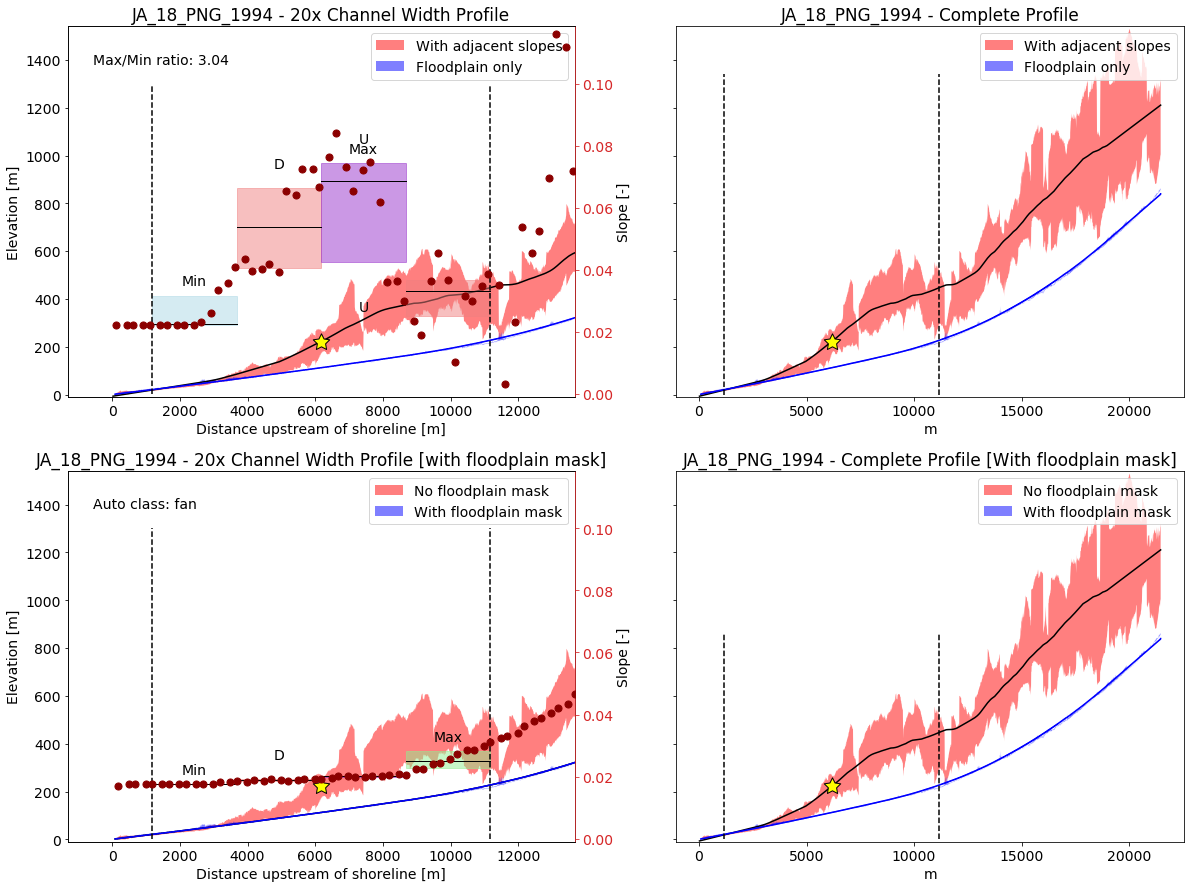

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


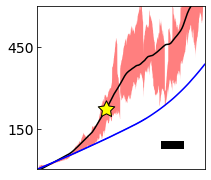

JA_4_Kosi_2008_2008
River width: 2000.0 m
20000.0
slope bin limit = 40000.0
slope bin size = 20000.0
slope measure window = 2000.0
Savitsky Golay smoothing window (floodplain) = 1001
Savitsky Golay smoothing window (no floodplain) = 501
Sample len: 30940


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


Min slope:0.000502946738102715
Max slope:0.018887861119865575
Max/Min ratio: 37.55
Min slope {FP}:0.0004607497765394628
Max slope {FP}:0.0010696172248800158


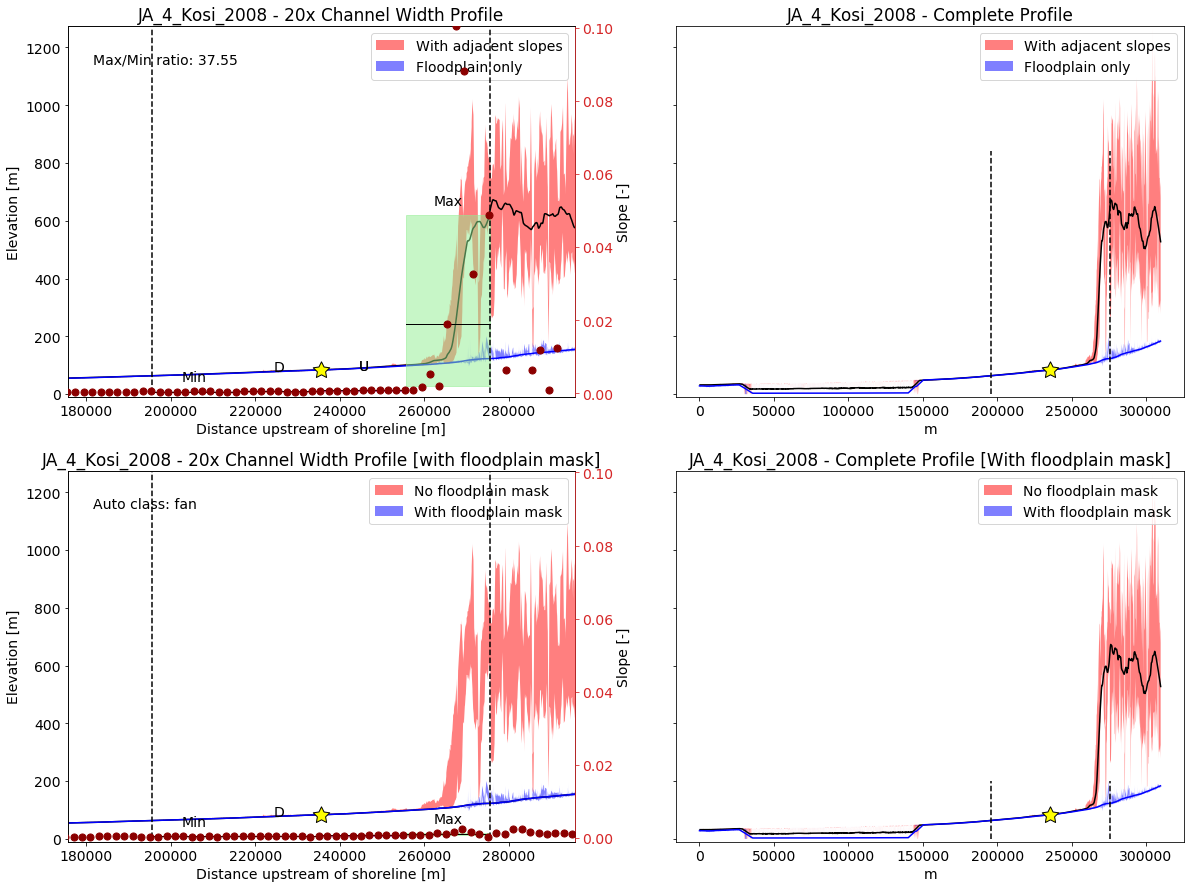

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


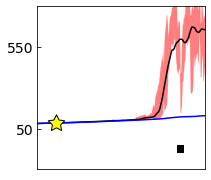

JA_69_PNG_2004_2009_2004
River width: 66.0 m
660.0
slope bin limit = 1320.0
slope bin size = 1320.0
slope measure window = 200
Savitsky Golay smoothing window (floodplain) = 1001
Savitsky Golay smoothing window (no floodplain) = 301
Sample len: 1616


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


Min slope:0.004916330773800297
Max slope:0.008677740863787219
Max/Min ratio: 1.77
Min slope {FP}:0.006272572936046003
Max slope {FP}:0.006302206799188639


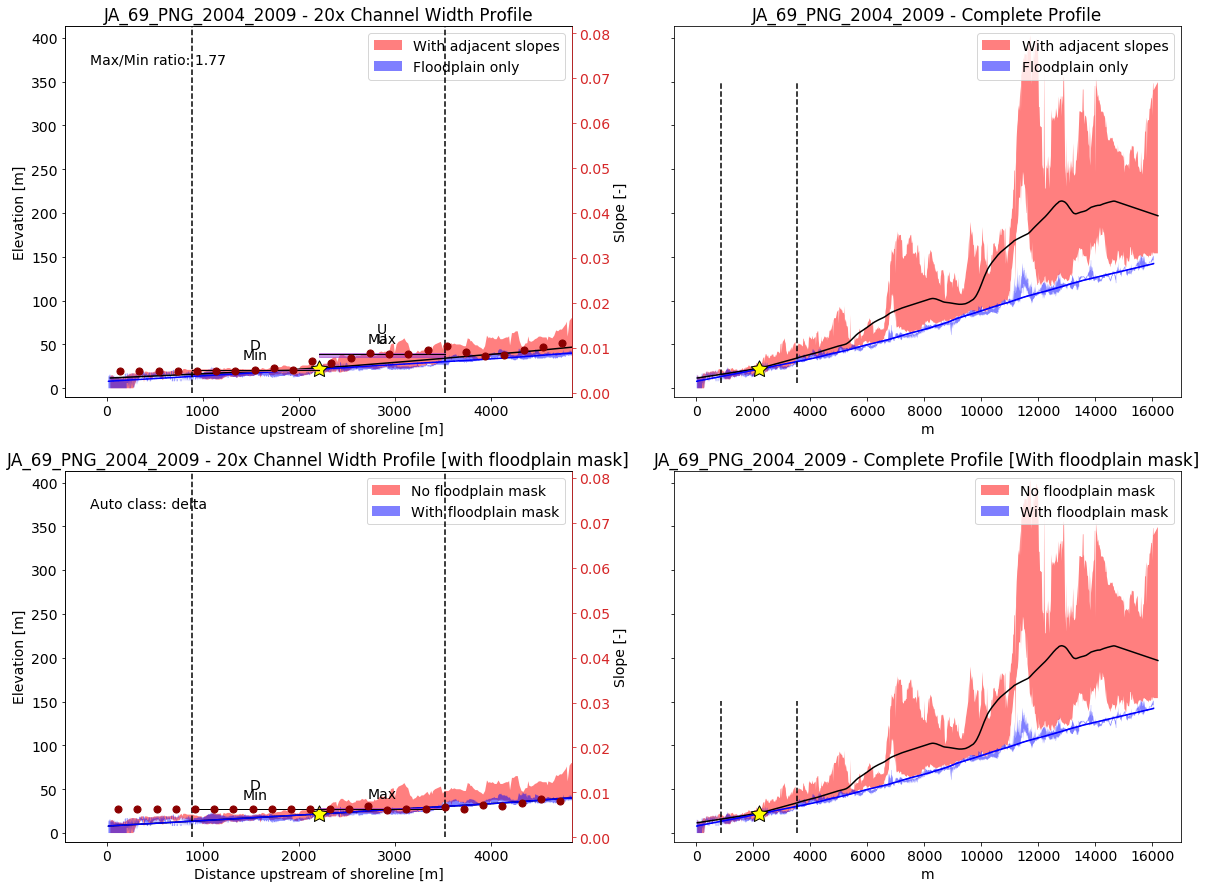

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


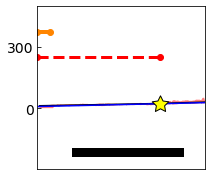

JA_95_PNG_1989_1989
River width: 72.0 m
720.0
slope bin limit = 1440.0
slope bin size = 1440.0
slope measure window = 200
Savitsky Golay smoothing window (floodplain) = 1001
Savitsky Golay smoothing window (no floodplain) = 301
Sample len: 1096


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


Min slope:0.004849266242766923
Max slope:0.004849266242766941
Max/Min ratio: 1.0
Min slope {FP}:0.004227912207552933
Max slope {FP}:0.004227912207552933


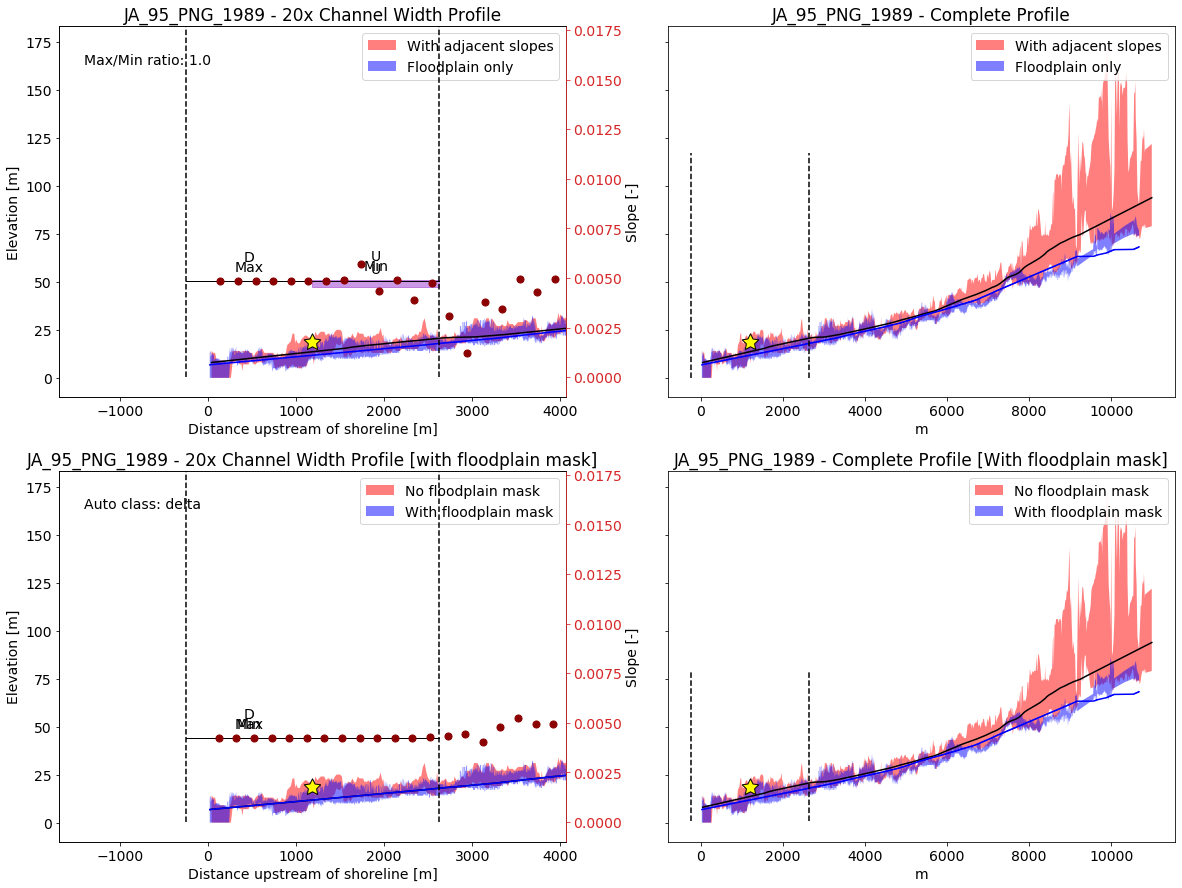

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


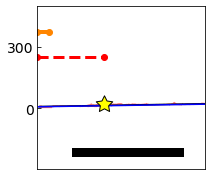

VENEZ1_1982
River width: 135.0 m
1350.0
slope bin limit = 2700.0
slope bin size = 1350.0
slope measure window = 200
Savitsky Golay smoothing window (floodplain) = 2501
Savitsky Golay smoothing window (no floodplain) = 1501
Sample len: 3336


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


Min slope:0.00012658227848096447
Max slope:0.00029580279813453905
Max/Min ratio: 2.34
Min slope {FP}:8.916433426634285e-05
Max slope {FP}:0.00033786485405826736


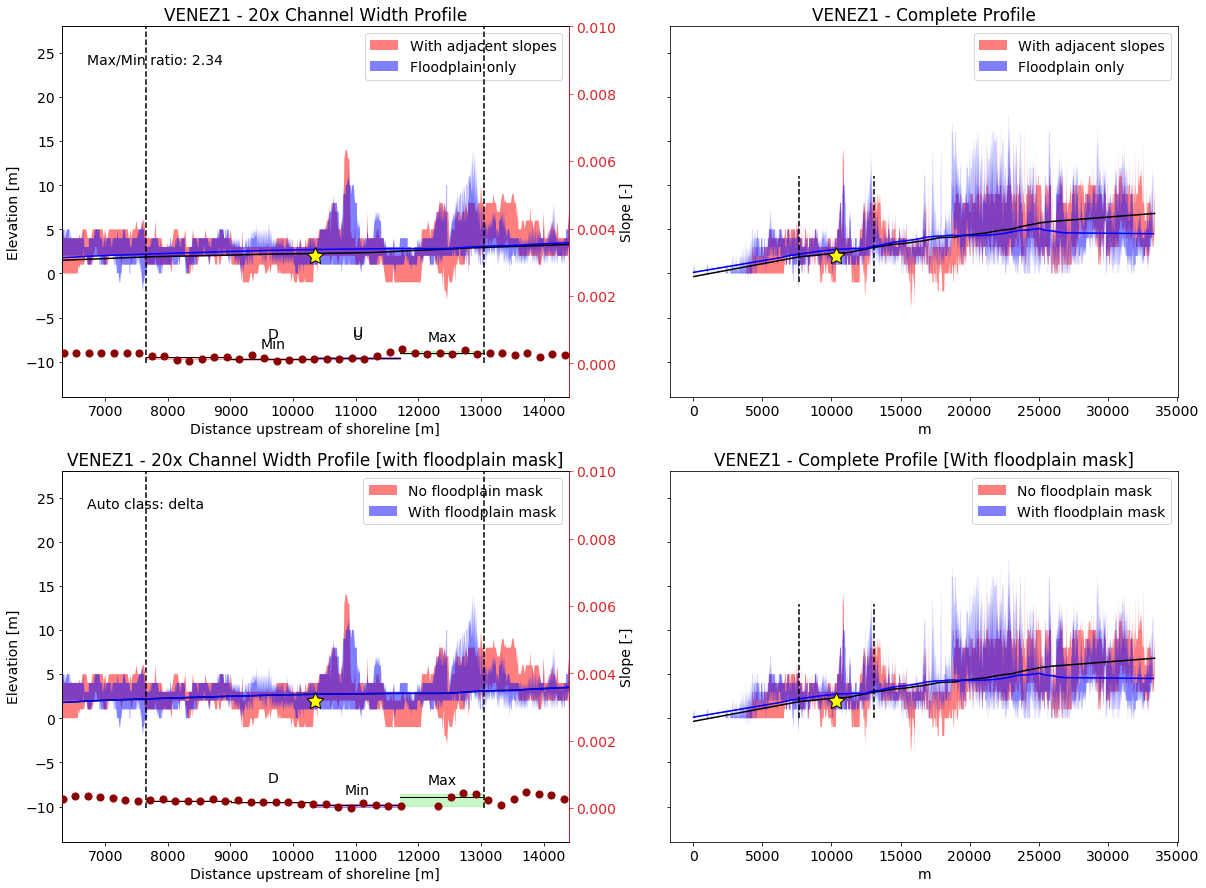

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


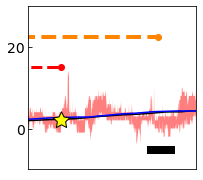

5
5
                 Av_ID      River  Year   From  L_A [km]  L_A_error [km]  \
0       JA_18_PNG_1994        NaN  1994  study     6.180               0   
1       JA_4_Kosi_2008        NaN  2008  study   235.633               0   
2  JA_69_PNG_2004_2009        NaN  2004  study     2.207               0   
3       JA_95_PNG_1989        NaN  1989  study     1.186               0   
4               VENEZ1  Catatumbo  1982  study    10.356               0   

      Wbf Auto Geomorph Class  Min S [-]  Min S_IQR [-]  ...  \
0   250.0                 fan   0.022583       0.009514  ...   
1  2000.0                 fan   0.000503       0.000073  ...   
2    66.0               delta   0.004916       0.000311  ...   
3    72.0               delta   0.004849       0.000358  ...   
4   135.0               delta   0.000127       0.000038  ...   

   Total Rise Over Run  Min S [-] {FP}  Min S_IQR [-] {FP}  Max S [-] {FP}  \
0             0.062506        0.017548        1.530546e-04        0.025112  

In [17]:
os.makedirs('./figures/profiles/', exist_ok=True)

import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy.interpolate import interp1d

profile_suffix = ['_SRTM3', '_AW3D30']

# To be populated
wbfs = []
upstream_slopes = []
upstream_slopes_IQR = []
downstream_slopes = []
downstream_slopes_IQR = []
immediate_upstream_slopes = []
immediate_upstream_slopes_IQR = []
immediate_downstream_slopes = []
immediate_downstream_slopes_IQR = []
total_rise_over_run = []
from_list = []
max_slopes = []
max_slopes_IQR = []
min_slopes = []
min_slopes_IQR = []
Max_Min_Ratios = []
auto_geomorph_class = []

upstream_slopes_fp = []
upstream_slopes_IQR_fp = []
downstream_slopes_fp = []
downstream_slopes_IQR_fp = []
immediate_upstream_slopes_fp = []
immediate_upstream_slopes_IQR_fp = []
immediate_downstream_slopes_fp = []
immediate_downstream_slopes_IQR_fp = []
total_rise_over_run_fp = []
max_slopes_fp = []
max_slopes_IQR_fp = []
min_slopes_fp = []
min_slopes_IQR_fp = []

La_list = []
avulsion_ids = []
avulsion_names = []
avulsion_years = []

fig_width_cm = 25.7                              # A4 page
fig_height_cm = 13
inches_per_cm = 1 / 2.54                         # Convert cm to inches
fig_width = fig_width_cm * inches_per_cm         # width in inches
fig_height = fig_height_cm * inches_per_cm       # height in inches
fig_size = [fig_width+2, fig_height+1]

font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 14}

mpl.rc('font', **font)
mpl.rcParams['pdf.fonttype'] = 42 # Truetype so text can be edited in Adobe Illustrator 
    
fig = plt.figure(constrained_layout=True)
fig.set_size_inches(fig_size)
gspec = gridspec.GridSpec(ncols=3, nrows=2, figure=fig)

# upstream_slope_len = 5000 # metres
min_slope_bin_size = 1000 # metres
chunks = 4 # target number of bins within study reach
av_inc_list = []
av_inc = 0

avulsion_db = pd.read_csv(os.path.join('avulsion_locations', 'avulsion_db_4326_slope_param.csv'))

av_keys = list(avulsion_distances_static.keys())

for idx, riv in avulsion_db.iterrows():

    if riv.AV_ID not in ['JA_95_PNG_1989', 'JA_69_PNG_2004_2009', 'JA_4_Kosi_2008', 'VENEZ1', 'JA_18_PNG_1994']:
        continue
        
    if riv.slope_process == 0:
        continue
    
    avulsion_id = riv.AV_ID+'_'+str(riv.year_est)
    

    if avulsion_id not in av_keys:
        avulsion_id = riv.AV_ID

    try:
        avulsion_distances_static[avulsion_id]
    except:
        print(avulsion_id+' not in avulsion_distances_static, skipping')
        continue
        
    print(avulsion_id)
    
    if riv.year_est > 0:
        try:
            int(riv.AV_ID[:-4])
            save_avulsion_id = riv.AV_ID+'_'+str(riv.year_est)
        except:
            save_avulsion_id = riv.AV_ID
    else:
        save_avulsion_id = riv.AV_ID
    
    wbf = riv.Wbf # Metres
    
    print('River width: '+str(wbf)+' m')
    skip = False
    elev_data_combined = pd.DataFrame()
    elev_data_combined_fp =  pd.DataFrame()
    
    for ps in profile_suffix:
    
        if os.path.exists(os.path.join(channel_iqr_profiles, avulsion_id+'_profile.csv')):
            
            elev_data = pd.read_csv(os.path.join(channel_iqr_profiles, avulsion_id+'_profile'+ps+'.csv'))
            elev_data_fp = pd.read_csv(os.path.join(channel_iqr_profiles_floodplain_mask, avulsion_id+'_profile'+ps+'.csv'))
        
        elif os.path.exists(os.path.join(channel_iqr_profiles, avulsion_id+'_profile'+ps+'.csv')):
            
            elev_data = pd.read_csv(os.path.join(channel_iqr_profiles, avulsion_id+'_profile'+ps+'.csv'))
            elev_data_fp = pd.read_csv(os.path.join(channel_iqr_profiles_floodplain_mask, avulsion_id+'_profile'+ps+'.csv'))
            
        elif os.path.exists(os.path.join(channel_iqr_profiles, riv.AV_ID+'_profile'+ps+'.csv')):
            
            elev_data = pd.read_csv(os.path.join(channel_iqr_profiles, riv.AV_ID+'_profile'+ps+'.csv'))
            elev_data_fp = pd.read_csv(os.path.join(channel_iqr_profiles_floodplain_mask, riv.AV_ID+'_profile'+ps+'.csv'))
            
        elif os.path.exists(os.path.join(channel_iqr_profiles, save_avulsion_id+'_profile'+ps+'.csv')):
            
            elev_data = pd.read_csv(os.path.join(channel_iqr_profiles, save_avulsion_id+'_profile'+ps+'.csv'))
            elev_data_fp = pd.read_csv(os.path.join(channel_iqr_profiles_floodplain_mask, save_avulsion_id+'_profile'+ps+'.csv'))
            
        else:
            print('CANNOT FIND PROFILE FOR '+avulsion_id)
            print('tried...')
            print(os.path.join(channel_iqr_profiles, avulsion_id+'_profile.csv'))
            print(os.path.join(channel_iqr_profiles, avulsion_id+'_profile'+ps+'.csv'))
            print(os.path.join(channel_iqr_profiles, riv.AV_ID+'_profile'+ps+'.csv'))
            print(os.path.join(channel_iqr_profiles, save_avulsion_id+'_profile'+ps+'.csv'))
            skip = True
        
        elev_data_combined = elev_data_combined.append(elev_data)
        elev_data_combined_fp = elev_data_combined_fp.append(elev_data_fp)
        
    if skip:
        continue
    
    wbfs.append(wbf)

    avulsion_ids.append(save_avulsion_id)
    avulsion_names.append(riv.river_name)
    avulsion_years.append(riv.year_est)
    
    from_list.append(riv['from'])
    
    av_inc_list.append(av_inc)
    av_inc = av_inc+1
    
    elev_data_combined = elev_data_combined[elev_data_combined['median'] != 'nan'] # Remove non numerics
    elev_data_combined = elev_data_combined[elev_data_combined['median'] <= 5000] # Remove invalid data (nodata is usually a high int)
    elev_data_combined = elev_data_combined[elev_data_combined['median'] > -500]
    elev_data_combined = elev_data_combined.sort_values('distance')
    elev_data_combined.reset_index(drop=True)

    if riv.reverse_needed:
        elev_data_combined['distance'] = abs(elev_data_combined['distance']-(np.max(elev_data_combined['distance'])))
    
    elev_data_combined_fp = elev_data_combined_fp[elev_data_combined_fp['median'] != 'nan'] # Remove non numerics
    elev_data_combined_fp = elev_data_combined_fp[elev_data_combined_fp['median'] <= 5000] # Remove invalid data (nodata is usually a high int)
    elev_data_combined_fp = elev_data_combined_fp[elev_data_combined_fp['stdev'] <= 20] # Any data with a stdev greater than 20 is spurious
    elev_data_combined_fp = elev_data_combined_fp.sort_values('distance')
    elev_data_combined_fp.reset_index(drop=True)

    if riv.reverse_needed:
        elev_data_combined_fp['distance'] = abs(elev_data_combined_fp['distance']-(np.max(elev_data_combined_fp['distance'])))
    
    # Standardised 10 metre interpolation
    def interp_col(x,y,new_x):
        f = interp1d(x, y)
        return f(new_x)
    
    distance_new = np.arange(elev_data_combined['distance'].min(), elev_data_combined['distance'].max(), 10)
    median_interp = interp_col(elev_data_combined['distance'],elev_data_combined['median'],distance_new)
    stdev_interp = interp_col(elev_data_combined['distance'], elev_data_combined['stdev'],distance_new)
    prc_25_interp = interp_col(elev_data_combined['distance'],elev_data_combined['prc_25'],distance_new)
    prc_75_interp = interp_col(elev_data_combined['distance'],elev_data_combined['prc_75'],distance_new)
    
    elev_data_combined_interp = pd.DataFrame({
        'distance':distance_new,
        'median':median_interp,
        'stdev':stdev_interp,
        'prc_25':prc_25_interp,
        'prc_75':prc_75_interp
    })
    
    elev_data_combined = elev_data_combined_interp.reset_index(drop=True)
    
    # Calculate total rise over run
    rise = np.max(elev_data_combined['median'])-np.min(elev_data_combined['median'])
    run = np.max(elev_data_combined['distance'])
    total_rise_over_run.append(rise/run)

    # Calculate total rise over run [with floodplain mask]
    rise_fp = np.max(elev_data_combined_fp['median'])-np.min(elev_data_combined_fp['median'])
    run_fp = np.max(elev_data_combined_fp['distance'])
    total_rise_over_run_fp.append(rise_fp/run_fp)
    
    if np.isnan(riv.min_elevations_m):
        min_height = np.nanmin(elev_data_combined['prc_25']-10)
    else:
        min_height = riv.min_elevations_m
    
    if np.isnan(riv.max_elevations_m):
        max_height = np.nanmax(elev_data_combined['prc_75']+10)
    else:
        max_height = riv.max_elevations_m

    if np.isnan(riv.min_distances_km):
        min_dist_m = np.nanin(elev_data_combined['distance'])
        min_dist_km = np.nanmin(elev_data_combined['distance'])/1000
    else:
        min_dist_m = riv.min_distances_km*1000
        min_dist_km = riv.min_distances_km
    
    if np.isnan(riv.max_distances_km):
        max_dist_m = np.nanmax(elev_data_combined['distance'])
        max_dist_km = np.nanmax(elev_data_combined['distance'])/1000
    else:
        max_dist_m = riv.max_distances_km*1000
        max_dist_km = riv.max_distances_km

    local_slope = []
    central_distances = []


    fig_profile, axes = plt.subplots(figsize=(20,15), nrows=2, ncols=2, sharey=True)
    ax_profile = axes[0][0]
    ax_complete_profile = axes[0][1]
    ax_profile_fp = axes[1][0]
    ax_complete_profile_fp = axes[1][1]
    axb = ax_profile.twinx()  # instantiate a second axes that shares the same x-axis
    axb_fp = ax_profile_fp.twinx()
    
    distance_km = [x / 1000 for x in elev_data_combined['distance']]

    La_list.append(avulsion_distances_static[avulsion_id][0]/1000)

    av_idxs = []
    av_dists = []
    av_elevs = []

    #slope_window_m = riv.avulsion_slope_distances_upstream
    slope_window_full = (wbf*width_multiple) # Study reach (distance upstream and downstream of the avulsion node)
    
    if slope_window_full < min_slope_bin_size:
        slope_window_m = slope_window_full
    else:
        estimated_chunk_size = (slope_window_full*2)/chunks

        print(estimated_chunk_size)
        if estimated_chunk_size < min_slope_bin_size:
            # Chunk size is too small, we need to increase the size
            
            min_chunk_multiples = (slope_window_full*2)/min_slope_bin_size # how many of the minimum size can fit?
            whole_chunks = np.floor(min_chunk_multiples) # how many minimum size chunks can fit?
            residual = min_chunk_multiples-whole_chunks # left over
            slope_window_m = min_slope_bin_size+(min_slope_bin_size*(residual/whole_chunks))
        else:
            slope_window_m = estimated_chunk_size
    
    slope_measure_window = slope_window_m/10 # 5 slope measurements per bin
    
    if slope_measure_window < 200:
        slope_measure_window = 200 # Use 150 metres a minimum 
    
    print('slope bin limit = '+str(slope_window_full))
    print('slope bin size = '+str(slope_window_m))
    print('slope measure window = '+str(slope_measure_window))
    
    for av_dist in avulsion_distances_static[avulsion_id]:
        av_idx_m = abs(elev_data_combined['distance'] - av_dist).idxmin()
        av_idxs.append(av_idx_m)
        av_elevs.append(float(elev_data_combined.iloc[av_idx_m]['median']))

    max_dist_idx = (np.abs(np.array(distance_km) - max_dist_km)).argmin()
    
    print('Savitsky Golay smoothing window (floodplain) = '+str(riv.smoothing_windows_fp))
    print('Savitsky Golay smoothing window (no floodplain) = '+str(riv.smoothing_windows))
    print('Sample len: '+str(len(elev_data_combined['median'])))
    
    smoothed_elevation = signal.savgol_filter(elev_data_combined['median'], riv.smoothing_windows, 1)
    smoothed_elevation_fp = signal.savgol_filter(elev_data_combined_fp['median'], riv.smoothing_windows_fp, 1)

    # Only plot upstream of elevation
    # elev_data_gt_av = (elev_data_combined['distance']> avulsion_distances_static[avulsion_id][0])
    # slope_x, slopes = get_local_slope(elev_data_combined['distance'][elev_data_gt_av], smoothed_elevation[elev_data_gt_av], window=1000) # Per m
    
    slope_x, slopes = get_local_slope(elev_data_combined['distance'], smoothed_elevation, window=slope_measure_window) # Per m
    slope_x_fp, slopes_fp = get_local_slope(elev_data_combined_fp['distance'], smoothed_elevation_fp, window=slope_measure_window) # Per m
    
    # Put into a dataframe
    slope_df = pd.DataFrame(list(zip(slope_x, slopes)), columns = ['x', 'slope'])
    slope_df = slope_df[slope_df['slope'] > 0] # Remove invalid data
    slope_df.reset_index(drop=True)

    slope_df_fp = pd.DataFrame(list(zip(slope_x_fp, slopes_fp)), columns = ['x', 'slope'])
    slope_df_fp = slope_df_fp[slope_df_fp['slope'] > 0] # Remove invalid data
    slope_df_fp.reset_index(drop=True)
    
    # Plot local slope on profile axis (No floodplain mask)
    ax_profile.plot(elev_data_combined['distance'],smoothed_elevation, color='black')
    axb.scatter(slope_df['x'], slope_df['slope'], 50, color='darkred', zorder=7)
    ax_profile.fill_between(elev_data_combined['distance'], elev_data_combined['prc_75'], elev_data_combined['prc_25'], facecolor='red', alpha=0.5, label='With adjacent slopes')
    ax_profile.fill_between(elev_data_combined_fp['distance'], elev_data_combined_fp['prc_75'], elev_data_combined_fp['prc_25'], facecolor='blue', alpha=0.5, label='Floodplain only')
    ax_profile.plot(elev_data_combined_fp['distance'],smoothed_elevation_fp, color='blue')
    
    # Plot complete profile (No floodplain mask)
    ax_complete_profile.plot(elev_data_combined['distance'],smoothed_elevation, color='black')
    ax_complete_profile.fill_between(elev_data_combined['distance'], elev_data_combined['prc_75'], elev_data_combined['prc_25'], facecolor='red', alpha=0.5, label='With adjacent slopes')
    ax_complete_profile.fill_between(elev_data_combined_fp['distance'], elev_data_combined_fp['prc_75'], elev_data_combined_fp['prc_25'], facecolor='blue', alpha=0.5, label='Floodplain only')
    ax_complete_profile.plot(elev_data_combined_fp['distance'],smoothed_elevation_fp, color='blue')
    
    if np.nanmax(slope_df['slope']) > 0.01:
        axb.set_ylim(-0.001, np.nanmax(slope_df['slope']))
    else:
        axb.set_ylim(-0.001, 0.01)
    
    for aidx, av_dist in enumerate(avulsion_distances_static[avulsion_id]):
        ax_profile.scatter(av_dist,av_elevs[aidx], s=300, marker=(5, 1), facecolors='yellow', edgecolors=(0, 0, 0), zorder=10)
        ax_complete_profile.scatter(av_dist,av_elevs[aidx], s=300, marker=(5, 1), facecolors='yellow', edgecolors=(0, 0, 0), zorder=10)

    ax_profile.set_xlabel('Distance upstream of shoreline [m]')
    axb.set_ylabel('Slope [-]')
    ax_profile.set_ylabel('Elevation [m]')
    axb.spines['right'].set_color('tab:red')
    axb.tick_params(axis='y', colors='tab:red')
    ax_profile.set_title(save_avulsion_id+' - '+str(width_multiple)+'x Channel Width Profile')
    
    ax_complete_profile.legend()
    ax_profile.legend()
    
    # Plot local slope on profile axis (With floodplain mask)
    ax_profile_fp.plot(elev_data_combined_fp['distance'],smoothed_elevation_fp, color='black')
    axb_fp.scatter(slope_df_fp['x'], slope_df_fp['slope'], 50, color='darkred', zorder=7)
    ax_profile_fp.fill_between(elev_data_combined['distance'], elev_data_combined['prc_75'], elev_data_combined['prc_25'], facecolor='red', alpha=0.5, label='No floodplain mask')
    ax_profile_fp.fill_between(elev_data_combined_fp['distance'], elev_data_combined_fp['prc_75'], elev_data_combined_fp['prc_25'], facecolor='blue', alpha=0.5, label='With floodplain mask')
    ax_profile_fp.plot(elev_data_combined_fp['distance'],smoothed_elevation_fp, color='blue')
    
    # Plot complete profile (With floodplain mask)
    ax_complete_profile_fp.plot(elev_data_combined['distance'],smoothed_elevation, color='black')
    ax_complete_profile_fp.fill_between(elev_data_combined['distance'], elev_data_combined['prc_75'], elev_data_combined['prc_25'], facecolor='red', alpha=0.5, label='No floodplain mask')
    ax_complete_profile_fp.fill_between(elev_data_combined_fp['distance'], elev_data_combined_fp['prc_75'], elev_data_combined_fp['prc_25'], facecolor='blue', alpha=0.5, label='With floodplain mask')
    ax_complete_profile_fp.plot(elev_data_combined_fp['distance'],smoothed_elevation_fp, color='blue')
    
    if np.nanmax(slope_df['slope']) > 0.01:
        axb_fp.set_ylim(-0.001, np.nanmax(slope_df['slope']))
    else:
        axb_fp.set_ylim(-0.001, 0.01)
    
    for aidx, av_dist in enumerate(avulsion_distances_static[avulsion_id]):
        ax_profile_fp.scatter(av_dist,av_elevs[aidx], s=300, marker=(5, 1), facecolors='yellow', edgecolors=(0, 0, 0), zorder=10)
        ax_complete_profile_fp.scatter(av_dist,av_elevs[aidx], s=300, marker=(5, 1), facecolors='yellow', edgecolors=(0, 0, 0), zorder=10)

    ax_profile_fp.set_xlabel('Distance upstream of shoreline [m]')
    axb_fp.set_ylabel('Slope [-]')
    ax_profile_fp.set_ylabel('Elevation [m]')
    axb_fp.spines['right'].set_color('tab:red')
    axb_fp.tick_params(axis='y', colors='tab:red')
    ax_profile_fp.set_title(save_avulsion_id+' - '+str(width_multiple)+'x Channel Width Profile [with floodplain mask]')
    
    ax_complete_profile_fp.legend()
    ax_profile_fp.legend()
    
    
    max_dist = slope_df.x.max()

    # Group slope values into windows bins
    
    if (avulsion_distances_static[avulsion_id][0]-slope_window_full) < 0:
        min_dist_slope_search = 0
    else:
        min_dist_slope_search = (avulsion_distances_static[avulsion_id][0]-slope_window_full)
        
    max_dist_slope_search = (avulsion_distances_static[avulsion_id][0]+slope_window_full)
    
    # Upstream
    wr_upstream = [avulsion_distances_static[avulsion_id][0]]
    max_len_met = False
    upstream_bin_edge = wr_upstream[0]
    while not max_len_met:
        upstream_bin_edge_new = upstream_bin_edge+slope_window_m
        if upstream_bin_edge_new > max_dist_slope_search:
            max_len_met = True
        else:
            wr_upstream.append(upstream_bin_edge_new)
            upstream_bin_edge = upstream_bin_edge_new

    # Downstream
    wr_downstream = [avulsion_distances_static[avulsion_id][0]-slope_window_m]
    min_len_met = False
    downstream_bin_edge = wr_downstream[0]
    while not min_len_met:
        downstream_bin_edge_new = downstream_bin_edge-slope_window_m
        if downstream_bin_edge_new < min_dist_slope_search:
            min_len_met = True
        else:
            wr_downstream.append(downstream_bin_edge_new)
            downstream_bin_edge = downstream_bin_edge_new
    
    wr_downstream.reverse()
    
    slope_bin_edges = np.concatenate((wr_downstream,wr_upstream))
    
    ax_profile.set_ylim(min_height, max_height)
    ax_profile.set_xlim(slope_bin_edges[0]-slope_window_m, slope_bin_edges[-1]+slope_window_m)        
    ax_profile_fp.set_ylim(min_height, max_height)
    ax_profile_fp.set_xlim(slope_bin_edges[0]-slope_window_m, slope_bin_edges[-1]+slope_window_m)        
            
    # Calculate stats per slope bin
    slope_window_groups = slope_df.groupby(pd.cut(slope_df["x"], slope_bin_edges))
    slope_binned = slope_window_groups.median() # Median slope for every window
    slope_bin_counts = slope_window_groups.count()
    slope_binned['count'] = slope_bin_counts.slope.values

    slope_window_groups_fp = slope_df_fp.groupby(pd.cut(slope_df_fp["x"], slope_bin_edges))
    slope_binned_fp = slope_window_groups_fp.median() # Median slope for every window
    slope_bin_counts_fp = slope_window_groups_fp.count()
    slope_binned_fp['count'] = slope_bin_counts_fp.slope.values
    
    # Minimum 3 data points in each bin
    
    ds = slope_window_groups.std()[slope_binned['count']>=3] # Slope error per window
    quart_25 = slope_window_groups.quantile(q=0.25)[slope_binned['count']>=3] # 25th pctile per window
    quart_75 = slope_window_groups.quantile(q=0.75)[slope_binned['count']>=3] # 75th pctile per window
    slope_binned = slope_binned.loc[slope_binned['count']>=3]

    ds_fp = slope_window_groups_fp.std()[slope_binned_fp['count']>=3] # Slope error per window
    quart_25_fp = slope_window_groups_fp.quantile(q=0.25)[slope_binned_fp['count']>=3] # 25th pctile per window
    quart_75_fp = slope_window_groups_fp.quantile(q=0.75)[slope_binned_fp['count']>=3] # 75th pctile per window
    slope_binned_fp = slope_binned_fp.loc[slope_binned_fp['count']>=3]
    
    # Add columns to slope_binned to create single dataframe
    slope_binned['std'] = list(ds.slope)
    slope_binned['pct_25'] = list(quart_25.slope)
    slope_binned['pct_75'] = list(quart_75.slope)
    slope_binned['idx'] = np.arange(len(slope_binned))
    
    slope_binned_fp['std'] = list(ds_fp.slope)
    slope_binned_fp['pct_25'] = list(quart_25_fp.slope)
    slope_binned_fp['pct_75'] = list(quart_75_fp.slope)
    slope_binned_fp['idx'] = np.arange(len(slope_binned_fp))
     
    intervals = slope_binned.index.tolist()
    slope_binned.index = range(0,len(list(ds.slope)))
    slope_binned.reset_index()

    intervals_fp = slope_binned_fp.index.tolist()
    slope_binned_fp.index = range(0,len(list(ds_fp.slope)))
    slope_binned_fp.reset_index()
    
    # Old logic to select steepest upstream bin and shallowest downstream bin
#     downstream_bins = slope_binned.loc[slope_binned.x<avulsion_distances_static[avulsion_id][0]]
#     upstream_bins = slope_binned.loc[slope_binned.x>=avulsion_distances_static[avulsion_id][0]]
    
#     print('Min slope:'+str(downstream_bins.slope.min()))
#     downstream_bins_min = downstream_bins.loc[downstream_bins.slope==downstream_bins.slope.min()].head(1)
#     if len(downstream_bins_min) < 1:
#         print('Downstream slope not found, substituting with first upstream bin')
#         downstream_bins_min = upstream_bins[upstream_bins.x == upstream_bins.x.min()].head(1)
        
        
#     print('Max slope:'+str(upstream_bins.slope.max()))
#     upstream_bins_max = upstream_bins.loc[upstream_bins.slope==upstream_bins.slope.max()].head(1)
    
#     print(downstream_bins_min)
#     print(upstream_bins_max)
    
#     # Avulsion distance upstream
#     con_d = avulsion_distances_static[avulsion_id][0]                                                               
#     av_idx = abs(slope_binned['x'] - con_d).idxmin() # Which bin is our avulsion in?
#     bin_idx = int(slope_binned.loc[av_idx]['idx']) # Index of bin that avulsion is on
    
    # Upstream bin
    con_d_upstream = avulsion_distances_static[avulsion_id][0]+(wbf*5)                                                          
    av_idx_upstream = abs(slope_binned['x'] - con_d_upstream).idxmin() # Which bin is our avulsion in?
    con_d_upstream_fp = avulsion_distances_static[avulsion_id][0]+(wbf*5)                                                          
    av_idx_upstream_fp = abs(slope_binned_fp['x'] - con_d_upstream_fp).idxmin() # Which bin is our avulsion in?
       
#     upstream_bin_idx = upstream_bins_max.index # Index of bin that avulsion is on    

    con_d_downstream = avulsion_distances_static[avulsion_id][0]-(wbf*5)
    av_idx_downstream = abs(slope_binned['x'] - con_d_downstream).idxmin()
    con_d_downstream_fp = avulsion_distances_static[avulsion_id][0]-(wbf*5)
    av_idx_downstream_fp = abs(slope_binned_fp['x'] - con_d_downstream_fp).idxmin()
    
#     # Box limits
    slope_neg_error = []
    slope_pos_error = []
    slope_val = []
    slope_center = []
    slope_neg_error_fp = []
    slope_pos_error_fp = []
    slope_val_fp = []
    slope_center_fp = []
    
#     # Get maximum upstream bin slope
#     upstream_slope = float(upstream_bins_max['slope'])
#     upstream_slopes.append(upstream_slope)
#     upstream_slope_IQR = float(upstream_bins_max['pct_75'])-float(upstream_bins_max['pct_25'])
#     upstream_slopes_IQR.append(upstream_slope_IQR)

#     # Get minimum downstream bin slope
#     downstream_slope = float(downstream_bins_min['slope'])
#     downstream_slopes.append(downstream_slope)
#     downstream_slope_IQR = float(downstream_bins_min['pct_75'])-float(downstream_bins_min['pct_25'])
#     downstream_slopes_IQR.append(downstream_slope_IQR)

    # Get slope immediately upstream of avulsion node
    immediate_upstream_slope_bin = slope_binned.loc[slope_binned.idx==av_idx_upstream]
    immediate_upstream_slope = float(immediate_upstream_slope_bin['slope'])
    immediate_upstream_slopes.append(immediate_upstream_slope)
    immediate_upstream_slope_IQR = float(immediate_upstream_slope_bin['pct_75'])-float(immediate_upstream_slope_bin['pct_25'])
    immediate_upstream_slopes_IQR.append(immediate_upstream_slope_IQR)
    
    # Get slope immediately upstream of avulsion node
    immediate_downstream_slope_bin = slope_binned.loc[slope_binned.idx==av_idx_downstream]
    immediate_downstream_slope = float(immediate_downstream_slope_bin['slope'])
    immediate_downstream_slopes.append(immediate_downstream_slope)
    immediate_downstream_slope_IQR = float(immediate_downstream_slope_bin['pct_75'])-float(immediate_downstream_slope_bin['pct_25'])
    immediate_downstream_slopes_IQR.append(immediate_downstream_slope_IQR)
    
    # Get slope immediately upstream of avulsion node [with floodplain mask]
    immediate_upstream_slope_bin_fp = slope_binned_fp.loc[slope_binned_fp.idx==av_idx_upstream_fp]
    immediate_upstream_slope_fp = float(immediate_upstream_slope_bin_fp['slope'])
    immediate_upstream_slopes_fp.append(immediate_upstream_slope_fp)
    immediate_upstream_slope_IQR_fp = float(immediate_upstream_slope_bin_fp['pct_75'])-float(immediate_upstream_slope_bin_fp['pct_25'])
    immediate_upstream_slopes_IQR_fp.append(immediate_upstream_slope_IQR_fp)
    
    # Get slope immediately upstream of avulsion node [with floodplain mask]
    immediate_downstream_slope_bin_fp = slope_binned_fp.loc[slope_binned_fp.idx==av_idx_downstream_fp]
    immediate_downstream_slope_fp = float(immediate_downstream_slope_bin_fp['slope'])
    immediate_downstream_slopes_fp.append(immediate_downstream_slope_fp)
    immediate_downstream_slope_IQR_fp = float(immediate_downstream_slope_bin_fp['pct_75'])-float(immediate_downstream_slope_bin_fp['pct_25'])
    immediate_downstream_slopes_IQR_fp.append(immediate_downstream_slope_IQR_fp)
    
    
#     print('Downstream slope: '+str(float(downstream_slope)))
#     print('Upstream slope: '+str(float(upstream_slope)))
#     print('Immediate upstream slope: '+str(float(immediate_upstream_slope_bin['slope'])))
    
    
    # Min max slope [no floodplain mask]
    print('Min slope:'+str(slope_binned.slope.min()))
    min_S = slope_binned.slope.min()
    min_slope_bin = slope_binned.loc[slope_binned.slope==slope_binned.slope.min()].head(1)   
    min_slopes.append(float(min_slope_bin['slope']))
    min_slopes_IQR.append(float(min_slope_bin['pct_75'])-float(min_slope_bin['pct_25']))
    print('Max slope:'+str(slope_binned.slope.max()))
    max_S = slope_binned.slope.max()
    max_slope_bin = slope_binned.loc[slope_binned.slope==slope_binned.slope.max()].head(1)  
    max_slopes.append(float(max_slope_bin['slope']))
    max_slopes_IQR.append(float(max_slope_bin['pct_75'])-float(max_slope_bin['pct_25']))
    
    max_min_ratio = round(max_S/min_S,2)
    Max_Min_Ratios.append(max_min_ratio)
    
    # Auto classification using min max slope ratio threshold of 3
    if max_min_ratio < 3:
        geomorph_class = 'delta'
    else:
        geomorph_class = 'fan'
        
    auto_geomorph_class.append(geomorph_class)
        
    print('Max/Min ratio: '+str(max_min_ratio))

    # Min max slope [with floodplain mask]
    print('Min slope {FP}:'+str(slope_binned_fp.slope.min()))
    min_S_fp = slope_binned_fp.slope.min()
    min_slope_bin_fp = slope_binned_fp.loc[slope_binned_fp.slope==slope_binned_fp.slope.min()].head(1)   
    min_slopes_fp.append(float(min_slope_bin_fp['slope']))
    min_slopes_IQR_fp.append(float(min_slope_bin_fp['pct_75'])-float(min_slope_bin_fp['pct_25']))
    print('Max slope {FP}:'+str(slope_binned_fp.slope.max()))
    max_S_fp = slope_binned_fp.slope.max()
    max_slope_bin_fp = slope_binned_fp.loc[slope_binned_fp.slope==slope_binned_fp.slope.max()].head(1)  
    max_slopes_fp.append(float(max_slope_bin_fp['slope']))
    max_slopes_IQR_fp.append(float(max_slope_bin_fp['pct_75'])-float(max_slope_bin_fp['pct_25']))
    
    # Without floodplain mask
    for index, row in slope_binned.iterrows():
        
        intv = intervals[index]
        b_left = intv.left
        b_right = intv.right
        b_bottom = float(row['pct_25'])
        b_top = float(row['pct_75'])
        b_width = b_right-b_left
        b_height = b_top-b_bottom

        slope_val.append(float(row['slope']))
        slope_neg_error.append(row['slope']-b_bottom)
        slope_pos_error.append(b_top-row['slope'])
        slope_center.append((b_left+b_right)/2)

        fcolor = 'lightcoral'

        upstream_slope = False
        
        if row['idx'] == max_slope_bin.index:
            fcolor = 'lightgreen'
            axb.annotate('Max', # this is the text
                         (b_left+(b_width/2),(b_bottom+b_height)), # this is the point to label
                         textcoords="offset points", # how to position the text#
                         xytext=(0,10), # distance from text to points (x,y)
                         ha='center')
        
        if row['idx'] == min_slope_bin.index:
            fcolor = 'lightblue'
            axb.annotate('Min', # this is the text
                         (b_left+(b_width/2),(b_bottom+b_height)), # this is the point to label
                         textcoords="offset points", # how to position the text
                         xytext=(0,10), # distance from text to points (x,y)
                         ha='center') 

        if row['idx'] == av_idx_upstream:
            fcolor = 'darkorchid'
            axb.annotate('U', # this is the text
                         (b_left+(b_width/2),(b_bottom+b_height)), # this is the point to label
                         textcoords="offset points", # how to position the text#
                         xytext=(0,20), # distance from text to points (x,y)
                         ha='center')
        
        if row['idx'] == av_idx_downstream:
            fcolor = 'lightcoral'
            axb.annotate('D', # this is the text
                         (b_left+(b_width/2),(b_bottom+b_height)), # this is the point to label
                         textcoords="offset points", # how to position the text
                         xytext=(0,20), # distance from text to points (x,y)
                         ha='center') 

#         if row['idx'] == av_idx_upstream:
#             fcolor = 'purple'
#             axb.annotate('A', # this is the text
#                          (b_left+(b_width/2),(b_bottom+b_height)), # this is the point to label
#                          textcoords="offset points", # how to position the text
#                          xytext=(0,10), # distance from text to points (x,y)
#                          ha='center') 
            
#         elif row['idx'] in dns_idxs:
#             fcolor = 'yellow'

        rect = patches.Rectangle((b_left,b_bottom),b_width,b_height,linewidth=1,
                                 edgecolor=fcolor,facecolor=fcolor, 
                                 fill=True, alpha=0.5)
    
        # Plot median value
        axb.plot([b_left, b_left+b_width], [float(row['slope']), float(row['slope'])], color='black', linewidth=1)
        
        axb.add_patch(rect)
    
    axb.plot([slope_bin_edges[-1], slope_bin_edges[-1]], [0, 0.1], 'k--')
    axb.plot([slope_bin_edges[0], slope_bin_edges[0]], [0, 0.1], 'k--')
    ax_complete_profile.plot([slope_bin_edges[-1], slope_bin_edges[-1]], [np.min(elev_data_combined['median']), np.max(elev_data_combined['median'])], 'k--')
    ax_complete_profile.plot([slope_bin_edges[0], slope_bin_edges[0]], [np.min(elev_data_combined['median']), np.max(elev_data_combined['median'])], 'k--')
        
    ax_complete_profile.set_xlabel('m')
    ax_complete_profile.set_title(save_avulsion_id+' - Complete Profile')
    
    axb.text(0.05, 0.9,'Max/Min ratio: '+str(round(max_S/min_S,2)), transform=axb.transAxes)
    
    # With floodplain mask
    for index, row in slope_binned_fp.iterrows():
        
        intv = intervals_fp[index]
        b_left = intv.left
        b_right = intv.right
        b_bottom = float(row['pct_25'])
        b_top = float(row['pct_75'])
        b_width = b_right-b_left
        b_height = b_top-b_bottom

        slope_val_fp.append(float(row['slope']))
        slope_neg_error_fp.append(row['slope']-b_bottom)
        slope_pos_error_fp.append(b_top-row['slope'])
        slope_center_fp.append((b_left+b_right)/2)

        fcolor = 'lightcoral'

        upstream_slope = False
        
        if row['idx'] == max_slope_bin_fp.index:
            fcolor = 'lightgreen'
            axb_fp.annotate('Max', # this is the text
                         (b_left+(b_width/2),(b_bottom+b_height)), # this is the point to label
                         textcoords="offset points", # how to position the text#
                         xytext=(0,10), # distance from text to points (x,y)
                         ha='center')
        
        if row['idx'] == min_slope_bin_fp.index:
            fcolor = 'lightblue'
            axb_fp.annotate('Min', # this is the text
                         (b_left+(b_width/2),(b_bottom+b_height)), # this is the point to label
                         textcoords="offset points", # how to position the text
                         xytext=(0,10), # distance from text to points (x,y)
                         ha='center') 

        if row['idx'] == av_idx_upstream_fp:
            fcolor = 'darkorchid'
            axb.annotate('U', # this is the text
                         (b_left+(b_width/2),(b_bottom+b_height)), # this is the point to label
                         textcoords="offset points", # how to position the text#
                         xytext=(0,20), # distance from text to points (x,y)
                         ha='center')
        
        if row['idx'] == av_idx_downstream_fp:
            fcolor = 'lightcoral'
            axb_fp.annotate('D', # this is the text
                         (b_left+(b_width/2),(b_bottom+b_height)), # this is the point to label
                         textcoords="offset points", # how to position the text
                         xytext=(0,20), # distance from text to points (x,y)
                         ha='center') 


        rect = patches.Rectangle((b_left,b_bottom),b_width,b_height,linewidth=1,
                                 edgecolor=fcolor,facecolor=fcolor, 
                                 fill=True, alpha=0.5)
    
        # Plot median value
        axb_fp.plot([b_left, b_left+b_width], [float(row['slope']), float(row['slope'])], color='black', linewidth=1)
        
        axb_fp.add_patch(rect)
    
    axb_fp.plot([slope_bin_edges[-1], slope_bin_edges[-1]], [0, 0.1], 'k--')
    axb_fp.plot([slope_bin_edges[0], slope_bin_edges[0]], [0, 0.1], 'k--')
    ax_complete_profile_fp.plot([slope_bin_edges[-1], slope_bin_edges[-1]], [np.min(elev_data_combined_fp['median']), np.max(elev_data_combined_fp['median'])], 'k--')
    ax_complete_profile_fp.plot([slope_bin_edges[0], slope_bin_edges[0]], [np.min(elev_data_combined_fp['median']), np.max(elev_data_combined_fp['median'])], 'k--')
        
    ax_complete_profile_fp.set_xlabel('m')
    ax_complete_profile_fp.set_title(save_avulsion_id+' - Complete Profile [With floodplain mask]')
    
    axb_fp.text(0.05, 0.9,'Auto class: '+geomorph_class, transform=axb_fp.transAxes)
    
    plt.savefig(os.path.join('figures', 'profiles', avulsion_id+'_all.png'))
    plt.show()
    plt.close()
    
    # Create minature plot for Fig 1
    fig_miniature, ax = plt.subplots(figsize=(3,3), nrows=1, ncols=1)
    ax_miniature_profile = ax
    ax_miniature_profile.tick_params(axis='y', direction="in")

#     # Plot local slope on profile axis (No floodplain mask)
#     ax_profile.plot(elev_data_combined['distance'],smoothed_elevation, color='black')
#     ax_profile.fill_between(elev_data_combined['distance'], elev_data_combined['prc_75'], elev_data_combined['prc_25'], facecolor='red', alpha=0.5, label='With adjacent slopes')
#     ax_profile.fill_between(elev_data_combined_fp['distance'], elev_data_combined_fp['prc_75'], elev_data_combined_fp['prc_25'], facecolor='blue', alpha=0.5, label='Floodplain only')
#     ax_profile.plot(elev_data_combined_fp['distance'],smoothed_elevation_fp, color='blue')
    
    # Plot complete profile (No floodplain mask)
    ax_miniature_profile.plot(elev_data_combined['distance'],smoothed_elevation, color='black')
    ax_miniature_profile.fill_between(elev_data_combined['distance'], elev_data_combined['prc_75'], elev_data_combined['prc_25'], facecolor='red', alpha=0.5, label='With adjacent slopes')
#     ax_miniature_profile.fill_between(elev_data_combined_fp['distance'], elev_data_combined_fp['prc_75'], elev_data_combined_fp['prc_25'], facecolor='blue', alpha=0.5, label='Floodplain only')
    ax_miniature_profile.plot(elev_data_combined_fp['distance'],smoothed_elevation_fp, color='blue')
    for aidx, av_dist in enumerate(avulsion_distances_static[avulsion_id]):
        ax_miniature_profile.scatter(av_dist,av_elevs[aidx], s=300, marker=(5, 1), facecolors='yellow', edgecolors=(0, 0, 0), zorder=10)

#     ax_miniature_profile.set_xlabel('Distance upstream of shoreline [m]')
#     ax_miniature_profile.set_ylabel('Elevation [m]')

    buffer = 8
    if riv.AV_ID == 'JA_18_PNG_1994':
        max_h = 600
        right_lim = 15000
        left_lim = 0
        Lb = False
        bottom_lim = 0
        height_full = max_h-bottom_lim
        ax_miniature_profile.set_xlim([left_lim, right_lim])
        ax_miniature_profile.set_ylim([bottom_lim, max_h])
        
    if riv.AV_ID == 'JA_95_PNG_1989':
        max_h = 500
        Lb = 205
        bottom_lim = -300
        left_lim = 0
        right_lim = 3000
        height_full = max_h-bottom_lim
        ax_miniature_profile.set_xlim([left_lim, right_lim])
        ax_miniature_profile.set_ylim([bottom_lim, max_h])

    if riv.AV_ID == 'JA_69_PNG_2004_2009':
        max_h = 500
        Lb = 233
        bottom_lim = -300
        right_lim = 3000
        left_lim = 0
        height_full = max_h-bottom_lim
        ax_miniature_profile.set_xlim([left_lim, right_lim])
        ax_miniature_profile.set_ylim([bottom_lim, max_h])
        
    if riv.AV_ID == 'JA_4_Kosi_2008':
        max_h = 800
        bottom_lim = -200
        Lb = False
        right_lim = 280000
        left_lim = 230000
        height_full = max_h-bottom_lim
        ax_miniature_profile.set_xlim([left_lim, right_lim])
        ax_miniature_profile.set_ylim([bottom_lim, max_h])
        
    if riv.AV_ID == 'VENEZ1':
        max_h = 30
        bottom_lim = -10
        Lb = 17300
        right_lim = 20000
        left_lim = 8000
        height_full = max_h-bottom_lim
        ax_miniature_profile.set_xlim([left_lim, right_lim])
        ax_miniature_profile.set_ylim([bottom_lim, max_h])
        
    right_space = (right_lim-left_lim)/buffer
    
    # Elevation Markers
    top_marker = int(max_h-(height_full/4))
    bottom_marker = int(bottom_lim+(height_full/4))
    
    if bottom_marker < 0:
        bottom_marker = 0

    ax_miniature_profile.set_yticks([bottom_marker, top_marker])
    ax_miniature_profile.set_xticks([])
    
    if Lb:
        Lb_line_y = max_h-(((max_h/buffer))*2)
        ax_miniature_profile.plot([0, Lb], [Lb_line_y,Lb_line_y], 'o--', linewidth=4, color='#ff8500')
        #ax_miniature_profile.plot([Lb], [Lb_line_y],  color='#f8b796')
        LA_line_y = max_h-((((max_h/buffer))*2)*2)
        ax_miniature_profile.plot([0, av_dist], [LA_line_y,LA_line_y], 'o--', linewidth=3, color='red')

    reference_width = 2000
    rect = patches.Rectangle((right_lim-(right_space+reference_width),bottom_lim+(max_h/buffer)),reference_width,height_full/20,linewidth=1,
                             facecolor='#000000', fill=True)
    ax_miniature_profile.add_patch(rect)
    ax_miniature_profile.tick_params(axis='y', direction="in")  
    plt.savefig(os.path.join('figures', 'profiles', avulsion_id+'_minuature.eps'), format='eps')
    plt.show()
    plt.close()
    
    
# Av_ID	River	From	LA [km]	S [-]	S_std [-]	D50 [m] (recorded)	Hbf [m] (recorded)	Hbf_std [m] (recorded)	Width [m]	DIS_AV_CMS	Cf	t_scour

print(len(avulsion_names))
print(len(avulsion_years))
avulsion_db_new = pd.DataFrame({
    'Av_ID':avulsion_ids,
    'River':avulsion_names,
    'Year':avulsion_years,
    'From':from_list,
    'L_A [km]':La_list,
    'L_A_error [km]':0,
    'Wbf':wbfs,
    'Auto Geomorph Class': auto_geomorph_class,
    'Min S [-]':min_slopes,
    'Min S_IQR [-]':min_slopes_IQR,
    'Max S [-]':max_slopes,
    'Max S_IQR [-]':max_slopes_IQR,
    'Max_Min_Ratio':Max_Min_Ratios,
    'Immediate Upstream S [-]':immediate_upstream_slopes,
    'Immediate Upstream S_IQR [-]':immediate_upstream_slopes_IQR,
    'Immediate Downstream S [-]':immediate_downstream_slopes,
    'Immediate Downstream S_IQR [-]':immediate_downstream_slopes_IQR,
    'Total Rise Over Run':total_rise_over_run,
    'Min S [-] {FP}':min_slopes_fp,
    'Min S_IQR [-] {FP}':min_slopes_IQR_fp,
    'Max S [-] {FP}':max_slopes_fp,
    'Max S_IQR [-] {FP}':max_slopes_IQR_fp,
    'Immediate Upstream S [-] {FP}':immediate_upstream_slopes_fp,
    'Immediate Upstream S_IQR [-] {FP}':immediate_upstream_slopes_IQR_fp,
    'Immediate Downstream S [-] {FP}':immediate_downstream_slopes_fp,
    'Immediate Downstream S_IQR [-] {FP}':immediate_downstream_slopes_IQR_fp,
    'Total Rise Over Run {FP}':total_rise_over_run_fp
#     'D50 [m] (recorded)':0,
#     'Hbf [m] (recorded)':0,
#     'Hbf_std [m] (recorded)':0,
#     'Width [m]':0,
#     'DIS_AV_CMS':0,
#     'L_b [km]':0,
#     'L_b_std_dev [km]':0,
#     'Cf':0,
#     'Tscour (months)':0,
#     'Tscour st.dev':0,
#     'Tscour std. err.':0,
#     'L_scour [km]':0,
#     'L_scour_std_dev [km]':0,
#     'T_e*':0,
#     'T_e* std_dev':0,
#     'T_e* std_err':0
}, index=av_inc_list)

if os.path.exists('./avulsion_locations/avulsion_db_4326_slope_populated_auto_class.csv'):
    os.remove('./avulsion_locations/avulsion_db_4326_slope_populated_auto_class.csv')
    
avulsion_db_new.to_csv('./avulsion_locations/avulsion_db_4326_slope_populated_auto_class.csv', index=False)
print(avulsion_db_new)